In [1]:
import pandas as pd
from PIL import Image
import os
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from matplotlib import pyplot as plt
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14, 8)
df=pd.read_csv('Relevent_Cards.csv', index_col=0)

Using TensorFlow backend.


In [2]:
df.head(5)

,multiverseid,name,artist,colors,colorIdentity,layout,cmc,rarity,type,subtypes,supertypes,power,toughness,set
0,130550.0,Ancestor's Chosen,Pete Venters,[White],[W],normal,7.0,Uncommon,Creature — Human Cleric,"[Human, Cleric]",NaN,4,4,10E
1,129465.0,Angel of Mercy,Volkan Baga,[White],[W],normal,5.0,Uncommon,Creature — Angel,[Angel],NaN,3,3,10E
2,129711.0,Angelic Blessing,Mark Zug,[White],[W],normal,3.0,Common,Sorcery,NaN,NaN,NaN,NaN,10E
3,129710.0,Angelic Chorus,Jim Murray,[White],[W],normal,5.0,Rare,Enchantment,NaN,NaN,NaN,NaN,10E
4,129671.0,Angelic Wall,John Avon,[White],[W],normal,2.0,Common,Creature — Wall,[Wall],NaN,0,4,10E


In [3]:
cards_with_images=df[df['multiverseid'].notnull()]
creature_cards=cards_with_images[['Creature' in i for i in cards_with_images['type'].values]]
creature_cards=creature_cards[creature_cards['subtypes'].notnull()]
destringed_substypes=[i[1:-1].split(', ') for i in creature_cards['subtypes'].values]
creature_cards['subtype_list']=pd.Series(destringed_substypes, index=creature_cards.index)

In [4]:
creature_cards[['name','subtype_list','multiverseid']].head(5)

,name,subtype_list,multiverseid
0,Ancestor's Chosen,"[Human, Cleric]",130550.0
1,Angel of Mercy,[Angel],129465.0
4,Angelic Wall,[Wall],129671.0
6,Aven Cloudchaser,"[Bird, Soldier]",129470.0
7,Ballista Squad,"[Human, Rebel]",129477.0


In [5]:
labels=pd.get_dummies(creature_cards['subtype_list'].apply(pd.Series).stack()).sum(level=0)
most_frequent_creature_types=labels.columns[labels.sum()>=110]
top_labels=labels[most_frequent_creature_types]

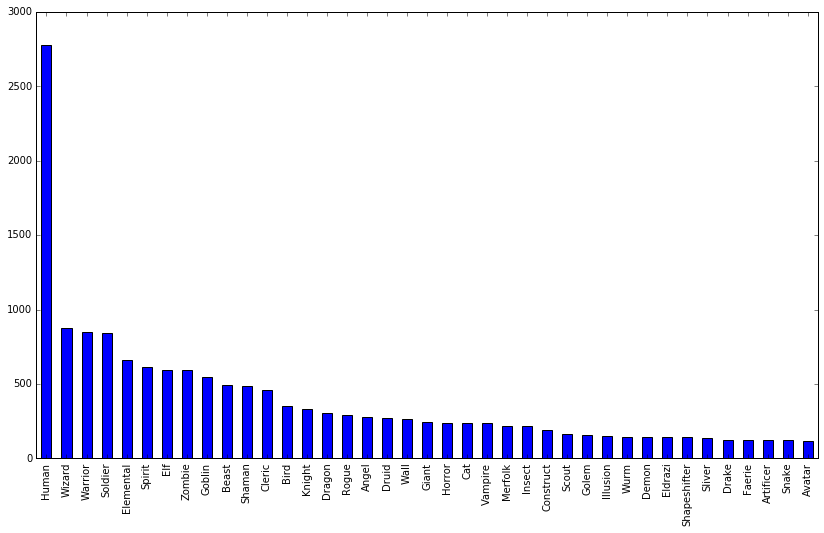

In [6]:
label_counts=top_labels.sum()
label_counts.sort_values(ascending=False).plot.bar()

In [7]:
creature_cards=creature_cards.join(top_labels)
in_top_labels=[sum(i) for i in creature_cards[top_labels.columns].values]
creature_cards['in_top_labels']=in_top_labels
number_of_types=[len(i) for i in creature_cards['subtype_list'].values]
creature_cards['number_of_types']=number_of_types
creature_cards=creature_cards[creature_cards['in_top_labels']==creature_cards['number_of_types']]

In [8]:
creature_cards.shape

(8867, 56)

In [9]:
shuffled=creature_cards.sample(frac=1)
train_set=shuffled[0:6000]
test_set=shuffled[6001:]

In [10]:
def load_and_crop_image(multiverse_id):
    im=cv2.imread('Cards/'+str(multiverse_id)+'.jpg')
    w, h, channels = im.shape
    return im[35:165, 25:195]
X_train=[]
X_test=[]
for i in train_set.multiverseid:
    X_train=X_train+[load_and_crop_image(int(i))]
for i in test_set.multiverseid:
    X_test=X_test+[load_and_crop_image(int(i))]
import numpy as np
from PIL import Image
X_train=np.array(X_train)
X_test=np.array(X_test)

In [12]:
y_train=train_set[top_labels.columns]
y_test=test_set[top_labels.columns]
y_train=np.array(y_train)
y_test=np.array(y_test)
y_train.shape

(6000, 39)

5944    [Angel, Spirit]
Name: subtypes, dtype: object


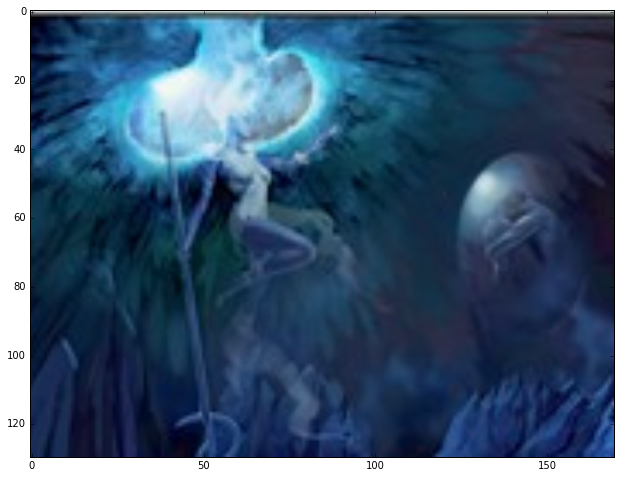

In [13]:
plt.imshow(X_train[0])
print train_set.head(1)['subtypes']

In [14]:
X_train = X_train.reshape(X_train.shape[0], 130, 170, 3)
X_test = X_test.reshape(X_test.shape[0], 130, 170, 3)

In [15]:
print X_train.shape

(6000, 130, 170, 3)


In [16]:
top_labels.shape

(13858, 39)

In [17]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [21]:
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(130,170, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (4, 4), activation='relu'))
model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Flatten())
model.add(Dropout(0.15))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(39, activation='sigmoid'))

In [22]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1)

Epoch 1/100
 224/6000 [>.............................] - ETA: 801s - loss: 0.6241 - acc: 0.6804

In [33]:
score = model.evaluate(X_test, y_test, verbose=0)

In [34]:
print score

[0.11546575036743673, 0.97409942345171063]


In [70]:
preds=model.predict(X_test)

In [71]:
test_frame=pd.DataFrame(preds, columns=top_labels.columns, index=test_set.index)

In [72]:
preds[preds >=0.9]=1
preds[preds < 0.9]=0

In [73]:
decoded_type=[]
for i in test_frame.index:
    row=test_frame.loc[i]
    typeline=[]
    for label in test_frame.columns:
        typeline=typeline+row[label]*[label]
    decoded_type=decoded_type+[typeline]

In [74]:
test_frame['decoded_typeline']=decoded_type

In [75]:
test_frame['true_typeline']=test_set['subtypes']

In [85]:
for i in test_frame['decoded_typeline'].values:
    if len(i)>0:
        print i

['Bird']
['Angel']
['Berserker', 'Goblin']
['Human', 'Soldier']
['Goblin']
['Human']
['Spirit']
['Human', 'Soldier']
['Elemental']
['Spider']
['Human']
['Human']
['Human']
['Human']
['Human']
['Faerie']
['Goblin', 'Wizard']
['Human']
['Druid', 'Elf']
['Zombie']
['Drake']
['Human']
['Human']
['Minotaur']
['Human']
['Angel']
['Human', 'Knight']
['Giant']
['Beast']
['Human']
['Wurm']
['Elf']
['Human']
['Elemental']
['Sliver']
['Angel']
['Human', 'Knight']
['Beast']
['Wizard']
['Skeleton']
['Beast']
['Human']
['Cleric', 'Human', 'Monk']
['Merfolk']
['Human']
['Human']
['Angel']
['Elemental']
['Angel']
['Human', 'Wizard']
['Human']
['Angel']
['Elemental']
['Elemental']
['Vampire']
['Goblin']
['Elemental']
['Human']
['Human']
['Elf']
['Construct']
['Druid', 'Human']
['Cat']
['Goblin']
['Horror']
['Knight']
['Angel']
['Human', 'Wizard']
['Goblin']
['Wurm']
['Drake']
['Soldier']
['Spirit']
['Cleric', 'Human']
['Beast']
['Spirit']
['Human']
['Human']
['Angel']
['Human']
['Zombie']
['Human']
['A

,true_typeline
26720,[Spirit]
6786,[Shapeshifter]
2054,[Wall]
1269,[Zombie]
3119,"[Human, Wizard]"
16324,"[Kithkin, Soldier]"
21965,[Illusion]
5934,[Angel]
28378,[Treefolk]
8405,"[Human, Wizard]"
